In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
# !pip install researchpy
# import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install pingouin
!pip install nbformat --upgrade
!pip install seaborn --upgrade


sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [12]:
def get_df(loc, select_reduction=1, trial = None):

  df = pd.read_csv(loc)

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(lambda x: x.replace('nan', '0'))
  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)

  df.columns = df.columns.str.lower()


  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['score (sum, mean, [list)']],
      axis=1)
  df.drop(columns=['score (sum, mean, [list)'], inplace=True)

  df['rank'] = df['rank'].astype('float')
  df['typical'] = df.apply(
      lambda row: row['rank']<28, # returns true if the item is in the context
      axis=1)

  df['experiment'] = df['rank']

  # check to see if trial num is incorrectly named. Sigh.
  if 'trial' in df.columns:
    df.rename(columns={'trial': 'trial_num'}, inplace=True)

  # override trial num
  if trial is not None:
    df['trial_num'] = trial

  df = df.explode('population data')
  df['member id'] = df.groupby(['trial_num', 'stimulus', 'item', 'category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')

  df['presentInContext'] = df.apply(
      lambda row: row['preamble'].count(row['item'])>1, # returns true if the item is in the context
      axis=1)


  return df

def get_df_no_reduction(loc, trial = None):

  df = pd.read_csv(loc)

  df[df['score (sum, mean, [list)'] == np.nan]['score (sum, mean, [list)'] = 0
  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)

  df.columns = df.columns.str.lower()


  df['population data'] = df.apply(
      lambda row: [2**t for t in row['score (sum, mean, [list)']],
      axis=1)
  df.drop(columns=['score (sum, mean, [list)'], inplace=True)

  df['rank'] = df['rank'].astype('float')
  df['typical'] = df.apply(
      lambda row: row['rank']<28, # returns true if the item is in the context
      axis=1)

  df['experiment'] = df['rank']

  # check to see if trial num is incorrectly named. Sigh.
  if 'trial' in df.columns:
    df.rename(columns={'trial': 'trial_num'}, inplace=True)

  # override trial num
  if trial is not None:
    df['trial_num'] = trial

  df = df.explode('population data')
  df['member id'] = df.groupby(['trial_num', 'stimulus', 'item', 'category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')

  df['presentInContext'] = df.apply(
      lambda row: row['preamble'].count(row['item'])>1, # returns true if the item is in the context
      axis=1)


  return df

def plot_categories(df, agg_method='mean', thresh=0.35, height = 7, aspect= 1.2):
  # this = df[df['stimulus']==group]
  # this = this[this['true_category']==group]
  this = df
  this = this.groupby(['category', 'trial_num', 'rank', 'stimulus'],
                      as_index=False).agg({'population data': agg_method,
                                          'true_category':'first',
                                           'stimulus':'first'})

  this['rank'] = this['rank'].max() - this['rank'].astype('float')

  this = this[this['population data']>thresh]

  this['color'] = this['true_category'].apply(lambda x: 'red' if x=='present' else 'blue')


  # this.groupby(['category']).plot.scatter(x='rank',
  #                                         y='population data',
  #                                         c='color',
  #                                         )

  g = sns.lmplot(x="rank",
             y="population data",
             data=this,
             hue="category",
             fit_reg=False,
             col="stimulus",
             row="true_category",
             height=height,
             aspect=aspect,
            #  sharex = True,
            #  sharey = True,
                 )

  g.axes[0][0].set_title('Canary: Absent ~ Actually: Absent', size = 10)
  g.axes[0][1].set_title('Canary: Present ~ Actually: Absent', size = 10)
  g.axes[1][0].set_title('Canary: Absent ~ Actually: Present', size = 10)
  g.axes[1][1].set_title('Canary: Present ~ Actually: Present', size = 10)

  g.set_axis_labels('', '')

  g.fig.supxlabel("Typicality")
  g.fig.supylabel("Population Canary Probability")
  g.fig.suptitle("Mistral In-Pretraining (Typicality) Fan Effect Details", y=1.05,  size=14)

  # print(this.groupby(['category'])[['rank', 'population data']].corr(method='pearson'))


def get_fan_correlations(df, agg_method='median', thresh=0.35, method = 'pearson', group='absent'):
  this = df[df['stimulus']==group]
  this = this[this['true_category']==group]
  this = this.groupby(['category', 'trial_num', 'rank'],
                      as_index=False).agg({'population data': agg_method,
                                          'true_category':'first'})

  this = this[this['population data']>thresh]
  this = this.groupby(['category'])[['rank', 'population data']].corr(method=method)
  this = this[this['rank']<1].reset_index()[['category','rank']]
  this['model'] = df['model'].unique()[0]
  return this.rename(columns={'rank': 'correlation'})


In [25]:
# Assuming your CSV file is named "data.csv"

loc = "/content/drive/MyDrive/Data/"

models = [
    'roberta-base',
    'GPT-2',
    'llama-2',
    'llama-3',
    'Mistral-7B',
    'SOLAR',
    ]

categories = ['weapon',
              'tool',
              'toy',
              'vehicle',
              'clothing',
              'fruit',
              'furniture',
              'sport',
              'vegetable',
              'birds',
              ]

In [26]:
# loop through all models and calculate the per category correlation and significance with typicality
# import plotly.graph_objects as go


all = pd.DataFrame()

exp = 'FanEffects/Typicality/results/'

for model in models:
  for category in categories:
    print(model, category)
    df = get_df(loc+exp+model+'/'+category+".csv")
    df['model'] = model
    df['category'] = category

    all = pd.concat([all, df])

roberta-base weapon
roberta-base tool
roberta-base toy
roberta-base vehicle
roberta-base clothing
roberta-base fruit
roberta-base furniture
roberta-base sport
roberta-base vegetable
roberta-base birds
GPT-2 weapon
GPT-2 tool
GPT-2 toy
GPT-2 vehicle
GPT-2 clothing
GPT-2 fruit
GPT-2 furniture
GPT-2 sport
GPT-2 vegetable
GPT-2 birds
llama-2 weapon
llama-2 tool
llama-2 toy
llama-2 vehicle
llama-2 clothing
llama-2 fruit
llama-2 furniture
llama-2 sport
llama-2 vegetable
llama-2 birds
llama-3 weapon
llama-3 tool
llama-3 toy
llama-3 vehicle
llama-3 clothing
llama-3 fruit
llama-3 furniture
llama-3 sport
llama-3 vegetable
llama-3 birds
Mistral-7B weapon
Mistral-7B tool
Mistral-7B toy
Mistral-7B vehicle
Mistral-7B clothing
Mistral-7B fruit
Mistral-7B furniture
Mistral-7B sport
Mistral-7B vegetable
Mistral-7B birds
SOLAR weapon
SOLAR tool
SOLAR toy
SOLAR vehicle
SOLAR clothing
SOLAR fruit
SOLAR furniture
SOLAR sport
SOLAR vegetable
SOLAR birds


In [42]:
def get_corrs_absent(df):
  corrs_absent = pd.DataFrame()

  threshes = {
      'roberta-base': 0.0,
      'GPT-2': 0.0,
      'llama-2': 0.0,
      'llama-3': 0.0,
      'Mistral-7B': 0.35,
      'SOLAR': 0.2,
      }

  for model in models:
    corrs_absent = pd.concat([corrs_absent, get_fan_correlations(df[df['model']==model],
                                                  thresh=threshes[model],
                                                  method='pearson')])
  return corrs_absent


def get_corrs_present(df):
  corrs_present = pd.DataFrame()

  threshes = {
      'roberta-base': 0.0,
      'GPT-2': 0.0,
      'llama-2': 0.0,
      'llama-3': 0.0,
      'Mistral-7B': 0.5,
      'SOLAR': 0.2,
      }

  for model in models:
    corrs_present = pd.concat([corrs_present, get_fan_correlations(df[df['model']==model],
                                                  thresh=threshes[model],
                                                  method='pearson',
                                                  group='present')])
  return corrs_present

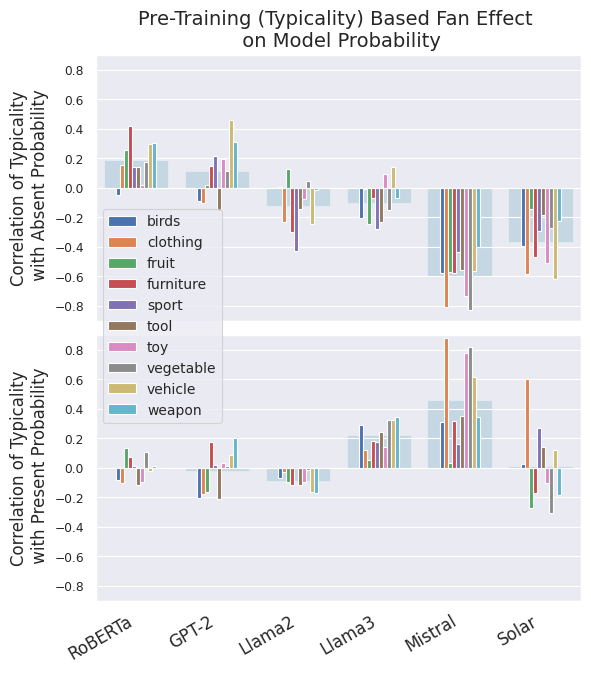

In [43]:
# Create a figure with subplots
fig, axs = plt.subplots(2,1,figsize=(6, 7), sharex=True)

# Generate probability correlation with typicality plot

result = get_corrs_absent(all)

result['correlation'] = result['correlation']*-1
result_total = result.groupby(["model"], sort=False).agg({
    'category': 'first',
    'correlation': 'mean',
    'model': 'first',
})

result.category = result.category.astype("category")
result.category = result.category.cat.set_categories(categories)

result.model = result.model.astype("category")
result.model = result.model.cat.set_categories(models)


grouped = result.groupby(['model', 'category'], sort=False)['correlation'].sum().unstack()

ax = axs[0]

ax.set_ylim(-0.9, 0.9)
# Create a bar chart
grouped.plot(kind='bar', ax=ax)
# sns.barplot(ax=ax, x=misracombined["model"], y=misracombined["correlation"], color='g', zorder=0, alpha=0.3)
sns.barplot(ax=ax,
            data=result_total,
            x='model',
            y='correlation',
            color='c', zorder=0, alpha=0.3)
# sns.barplot(ax=ax, x=high["model"], y=high["correlation"], color='c', zorder=0, alpha=0.3)

# Set the title and axis labels
ax.set_title('Pre-Training (Typicality) Based Fan Effect \n on Model Probability', size=14 )
ax.set_ylabel("Correlation of Typicality\n with Absent Probability", size=12)

handles, labels = ax.get_legend_handles_labels()
# ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left', fancybox=True, framealpha=0.5)
ax.legend(title='Category',
          loc='upper left',
          fancybox=True,
          framealpha=0.5,
          bbox_to_anchor=(0,0.4),
          ncol=1,
          fontsize=10,
          title_fontsize=10)

ax.legend().remove()

# ax.text(0.9, 0.69, '*p>0.05 not shown', fontsize=9)

# ax.annotate('Total population correlation for all categories.',
#                   xy=(1.6, 0.18), xycoords='data',
#                   xytext=(1.4, -0.02), textcoords='data',
#                   size=10, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   fc="black", ec='black'))

# ax.annotate('Total correlation for highly represented training \n categories [weapon, vehicle, sport, furniture, toy].',
#                   xy=(3.4, 0.4), xycoords='data',
#                   xytext=(3.6, -0.09), textcoords='data',
#                   size=10, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   fc="black", ec='black'))



# ax.annotate('Species base model total \n correlation for all categories.',
#                   xy=(5.6, 0.23), xycoords='data',
#                   xytext=(5.4, -0.03), textcoords='data',
#                   size=10, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   fc="black", ec='black'))

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=30, ha="right")

# Remove the x label
plt.xlabel('')



# SECOND GRAPH




result = get_corrs_present(all)

result['correlation'] = result['correlation']*-1
result_total = result.groupby(["model"], sort=False).agg({
    'category': 'first',
    'correlation': 'mean',
    'model': 'first',
})

result.category = result.category.astype("category")
result.category = result.category.cat.set_categories(categories)

result.model = result.model.astype("category")
result.model = result.model.cat.set_categories(models)


grouped = result.groupby(['model', 'category'], sort=False)['correlation'].sum().unstack()

ax = axs[1]

ax.set_ylim(-0.9, 0.9)

# Create a bar chart
grouped.plot(kind='bar', ax=ax)
# sns.barplot(ax=ax, x=misracombined["model"], y=misracombined["correlation"], color='g', zorder=0, alpha=0.3)
sns.barplot(ax=ax,
            data=result_total,
            x='model',
            y='correlation',
            color='c', zorder=0, alpha=0.3)
# sns.barplot(ax=ax, x=high["model"], y=high["correlation"], color='c', zorder=0, alpha=0.3)

# Set the title and axis labels
# ax.set_title('Pre-Training Based Fan Effect on Model Certainty', size=12 )
ax.set_xlabel('')
ax.set_ylabel("Correlation of Typicality\n with Present Probability", size=12)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left', fancybox=True, framealpha=0.5)
# ax.legend(title='Category', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1), ncol=2)

ax.legend().remove()


# Rotate the x-axis labels for better visibility
plt.xticks(rotation=30, ha="right", size=12)

# Remove the x label
plt.xlabel('')

# plt.ylabel("Correlation of Model Probability with Typicality", size=10)


plt.margins(x=0.01)
plt.subplots_adjust(hspace = 0)
plt.tight_layout()

plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0,1.5)).set_zorder(100)

ax.set_xticklabels(['RoBERTa', 'GPT-2', 'Llama2', 'Llama3', 'Mistral', 'Solar'])

# show the graph
plt.show()

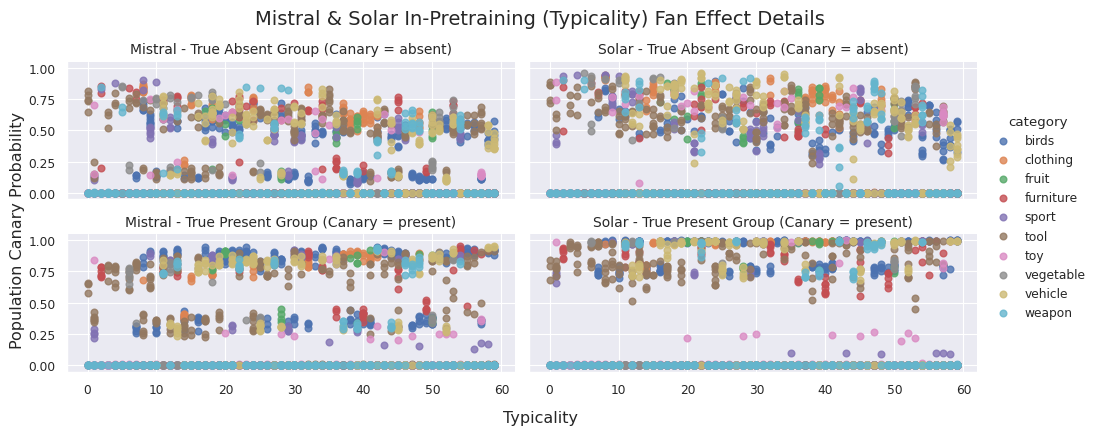

In [41]:
def plot_categories(df, agg_method='mean', thresh=0.35, height = 7, aspect= 1.2):
  # this = df[df['stimulus']==group]
  # this = this[this['true_category']==group]
  this = df
  this = this.groupby(['model', 'category', 'trial_num', 'rank', 'stimulus'],
                      as_index=False).agg({'population data': agg_method,
                                          'true_category':'first',
                                           'stimulus':'first',
                                           'model':'first'})

  this['rank'] = this['rank'].max() - this['rank'].astype('float')

  this = this[this['population data']>thresh]

  this = this[this['true_category']==this['stimulus']]


  # this.groupby(['category']).plot.scatter(x='rank',
  #                                         y='population data',
  #                                         c='color',
  #                                         )

  g = sns.lmplot(x="rank",
             y="population data",
             data=this,
             hue="category",
             fit_reg=False,
             col="model",
             row="true_category",
             height=height,
             aspect=aspect,
            #  sharex = True,
            #  sharey = True,
                 )

  g.axes[0][0].set_title('Mistral - True Absent Group (Canary = absent)', size = 10)
  g.axes[0][1].set_title('Solar - True Absent Group (Canary = absent)', size = 10)
  g.axes[1][0].set_title('Mistral - True Present Group (Canary = present)', size = 10)
  g.axes[1][1].set_title('Solar - True Present Group (Canary = present)', size = 10)

  g.set_axis_labels('', '')

  g.fig.supxlabel("Typicality")
  g.fig.supylabel("Population Canary Probability")
  g.fig.suptitle("Mistral & Solar In-Pretraining (Typicality) Fan Effect Details", y=1.05,  size=14)

  # print(this.groupby(['category'])[['rank', 'population data']].corr(method='pearson'))
# Use this code to evaluate qualitatively the natural breakpoint in the population members
# plot_categories(all[all['model']=='Mistral-7B'], agg_method='median', thresh=0, height=2, aspect=2.5)
plot_categories(all[(all['model']=='Mistral-7B') | (all['model']=='SOLAR')], agg_method='median', thresh=0, height=2, aspect=2.5)

In [3]:
AndersonDF = pd.DataFrame(list(zip(['SOLAR'] * 4 + ['Mistral'] * 4,
                                  (['Person'] + ['Place'])*4,
                                   (['Absent'] * 2 + ['Present'] * 2) * 2,
                                    [-0.232, 0.194, -0.011, -0.221, -0.397, -0.168, 0.516, 0.060],
                                    [1,1,0.4,0.4,1,1,0.4,0.4])),
                                  columns=['Experiment', 'Fan Type', 'Actual', 'Correlation','alpha'] )


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(-0.4, 0.2, 'transparency denotes\n p>0.01')

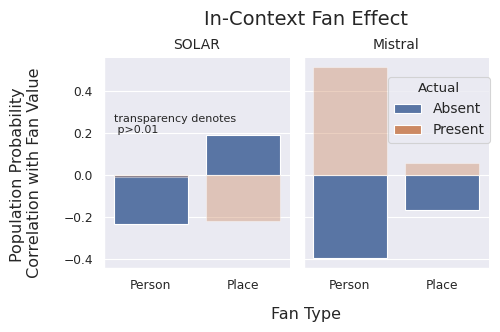

In [9]:
# AndersonDF.groupby(['Canary', 'Experiment', 'Fan Type'], sort=False)['Correlation'].sum().unstack().plot(kind='bar')

g = sns.FacetGrid(AndersonDF, col='Experiment', hue='Actual', col_wrap=2, height=3, aspect=0.8)
g.map(sns.barplot, 'Fan Type', 'Correlation')


rectangles = [item for ax in g.axes for container in ax.containers for item in container]

g.add_legend(title='Actual',
          loc='upper left',
          fancybox=True,
          # framealpha=0.9,
          frameon=True,
          bbox_to_anchor=(0.63,0.85),
          ncol=1,
          fontsize=10)

for bar, alpha in zip(rectangles, AndersonDF['alpha']):
  bar.set_alpha(alpha)

g.axes[1].set_title('Mistral', size = 10)
g.axes[0].set_title('SOLAR', size = 10)


g.set_axis_labels('', '')

g.fig.supxlabel("Fan Type")
g.fig.supylabel("Population Probability\n Correlation with Fan Value", ha='center')
g.fig.suptitle("In-Context Fan Effect", y=1.05,  size=14)

g.axes[0].text(-0.4, 0.2, 'transparency denotes\n p>0.01', fontsize=8)


In [186]:


typDF = pd.DataFrame()

exp = 'FanEffects/Typicality/results/'


typDF = get_df_no_reduction(loc+exp+'Mistral-7B'+'/'+'typicality_old'+".csv",  trial = 1)
typDF['model'] = 'Mistral-7B'


In [187]:
typDF

,preamble,stimulus,item,true_category,category,rank,params,model,population data,typical,experiment,trial_num,member id,presentInContext
0,A doll is a,toy.,doll,none,toy,1.0,7241732096,Mistral-7B,0.002842,True,1.0,1,1,False
0,A doll is a,toy.,doll,none,toy,1.0,7241732096,Mistral-7B,0.005248,True,1.0,1,2,False
0,A doll is a,toy.,doll,none,toy,1.0,7241732096,Mistral-7B,0.000649,True,1.0,1,3,False
0,A doll is a,toy.,doll,none,toy,1.0,7241732096,Mistral-7B,0.000544,True,1.0,1,4,False
0,A doll is a,toy.,doll,none,toy,1.0,7241732096,Mistral-7B,0.000281,True,1.0,1,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,A shoe is a,weapon.,shoe,none,weapon,60.0,7241732096,Mistral-7B,0.002510,False,60.0,1,46,False
564,A shoe is a,weapon.,shoe,none,weapon,60.0,7241732096,Mistral-7B,0.000845,False,60.0,1,47,False
564,A shoe is a,weapon.,shoe,none,weapon,60.0,7241732096,Mistral-7B,0.000780,False,60.0,1,48,False
564,A shoe is a,weapon.,shoe,none,weapon,60.0,7241732096,Mistral-7B,0.000779,False,60.0,1,49,False


0.14770849051481813


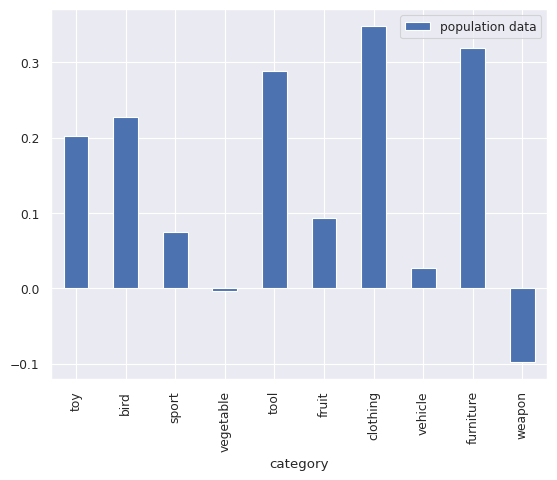

In [190]:
grouped = typDF.groupby(['category', 'preamble'], sort=False).agg({
    'population data': 'median',
    'rank': 'first',
})

this = grouped.reset_index().groupby(['category'], sort=False)[['population data', 'rank']].corr(method='pearson')
this = this[this['population data']<1].reset_index()
this['population data'] = this['population data'] * -1
this.plot(kind='bar', x='category', y='population data')

print(this['population data'].median())